<a href="https://colab.research.google.com/github/ahatesham02/News-Classifier/blob/main/News_Classifier_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#import nltk library

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
import string
nltk.download('punkt')
nltk.download('stopwords')
from wordcloud import WordCloud,STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# machine learning libraries

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# from collection import Counter

# deep learning libraries

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Embedding
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Import Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
from zipfile import ZipFile
filename='/content/drive/MyDrive/archive.zip'
unzip= ZipFile(filename,'r')
unzip.extractall()


In [4]:
fake_news= pd.read_csv('Fake.csv')
true_news= pd.read_csv('True.csv')

In [5]:
print(fake_news.shape)
print(true_news.shape)

(23481, 4)
(21417, 4)


In [6]:
fake_news.info()
true_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [7]:
fake_news.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


## Data Preprocessing and Cleaning

News has to be classified based on the tile and text jointly. Treating the title and content of news separately doesn't reap us any benefit. So, lets concatenate both the columns in both datasets

In [8]:
fake_news['news']= fake_news['title']+ fake_news['text']
true_news['news']= true_news['title']+ true_news['text']

In [9]:
fake_news.drop(['title', 'text'], axis=1)
true_news.drop(['title', 'text'], axis=1)

,subject,date,news
0,politicsNews,"December 31, 2017","As U.S. budget fight looms, Republicans flip t..."
1,politicsNews,"December 29, 2017",U.S. military to accept transgender recruits o...
2,politicsNews,"December 31, 2017",Senior U.S. Republican senator: 'Let Mr. Muell...
3,politicsNews,"December 30, 2017",FBI Russia probe helped by Australian diplomat...
4,politicsNews,"December 29, 2017",Trump wants Postal Service to charge 'much mor...
...,...,...,...
21412,worldnews,"August 22, 2017",'Fully committed' NATO backs new U.S. approach...
21413,worldnews,"August 22, 2017",LexisNexis withdrew two products from Chinese ...
21414,worldnews,"August 22, 2017",Minsk cultural hub becomes haven from authorit...
21415,worldnews,"August 22, 2017",Vatican upbeat on possibility of Pope Francis ...


In [10]:
fake_news['output']=0
true_news['output']=1

In [11]:
fake_news= fake_news[['subject', 'date', 'news', 'output']]
true_news= true_news[['subject', 'date', 'news', 'output']]

In [12]:
true_news.head(2)

,subject,date,news,output
0,politicsNews,"December 31, 2017","As U.S. budget fight looms, Republicans flip t...",1
1,politicsNews,"December 29, 2017",U.S. military to accept transgender recruits o...,1


In [13]:
fake_news.date.value_counts()

May 10, 2017                                                                                46
May 6, 2016                                                                                 44
May 26, 2016                                                                                44
May 5, 2016                                                                                 44
May 11, 2016                                                                                43
                                                                                            ..
https://100percentfedup.com/video-hillary-asked-about-trump-i-just-want-to-eat-some-pie/     1
Jun 7, 2015                                                                                  1
November 20, 2017                                                                            1
October 9, 2017                                                                              1
Apr 2, 2015                                       

In [14]:
#Removing links and the headline from the date column
fake_news=fake_news[~fake_news.date.str.contains("http")]
fake_news=fake_news[~fake_news.date.str.contains("HOST")]

In [15]:
fake_news.date= pd.to_datetime(fake_news.date)

In [16]:
true_news.date.value_counts()

December 20, 2017     182
December 6, 2017      166
November 30, 2017     162
November 9, 2017      158
October 13, 2017      155
                     ... 
December 25, 2016       1
May 14, 2016            1
December 30, 2017       1
January 24, 2016        1
May 22, 2016            1
Name: date, Length: 716, dtype: int64

In [17]:
true_news.date= pd.to_datetime(true_news.date)

In [18]:
# concate fake and true news
news= pd.concat([fake_news, true_news])
news.head()

,subject,date,news,output
0,News,2017-12-31,Donald Trump Sends Out Embarrassing New Year’...,0
1,News,2017-12-31,Drunk Bragging Trump Staffer Started Russian ...,0
2,News,2017-12-30,Sheriff David Clarke Becomes An Internet Joke...,0
3,News,2017-12-29,Trump Is So Obsessed He Even Has Obama’s Name...,0
4,News,2017-12-25,Pope Francis Just Called Out Donald Trump Dur...,0


In [19]:
news.shape

(44888, 4)

## Text Preprocessing

In [20]:
news_head= news.copy()
news_head= news_head[['news']].reset_index(drop=True)
news_head.head()

,news
0,Donald Trump Sends Out Embarrassing New Year’...
1,Drunk Bragging Trump Staffer Started Russian ...
2,Sheriff David Clarke Becomes An Internet Joke...
3,Trump Is So Obsessed He Even Has Obama’s Name...
4,Pope Francis Just Called Out Donald Trump Dur...


In [21]:
clean_news= news.copy().reset_index()
clean_news.head()

,index,subject,date,news,output
0,0,News,2017-12-31,Donald Trump Sends Out Embarrassing New Year’...,0
1,1,News,2017-12-31,Drunk Bragging Trump Staffer Started Russian ...,0
2,2,News,2017-12-30,Sheriff David Clarke Becomes An Internet Joke...,0
3,3,News,2017-12-29,Trump Is So Obsessed He Even Has Obama’s Name...,0
4,4,News,2017-12-25,Pope Francis Just Called Out Donald Trump Dur...,0


In [22]:
def review_cleaning(review):
  for i in range(len(clean_news)):
    review= re.sub('[^a-zA-Z]', ' ', clean_news['news'][i])
    review= review.lower()
    review= review.split()

    review= [ word for word in review if not word in stopwords.words('english')]
    review= ' '.join(review)
    return review

In [23]:
clean_news['news']= clean_news['news'].apply( lambda x: review_cleaning(x))
clean_news.head()

,index,subject,date,news,output
0,0,News,2017-12-31,donald trump sends embarrassing new year eve m...,0
1,1,News,2017-12-31,donald trump sends embarrassing new year eve m...,0
2,2,News,2017-12-30,donald trump sends embarrassing new year eve m...,0
3,3,News,2017-12-29,donald trump sends embarrassing new year eve m...,0
4,4,News,2017-12-25,donald trump sends embarrassing new year eve m...,0


Text(0.5, 1.0, 'Count fake or true news')

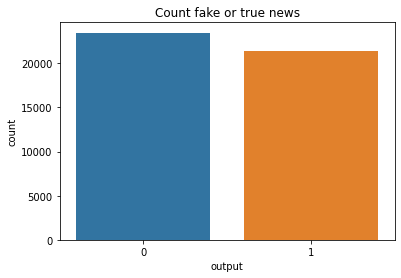

In [24]:
sns.countplot(x='output', data= clean_news)
plt.title('Count fake or true news')

Text(0.5, 1.0, 'Types of News')

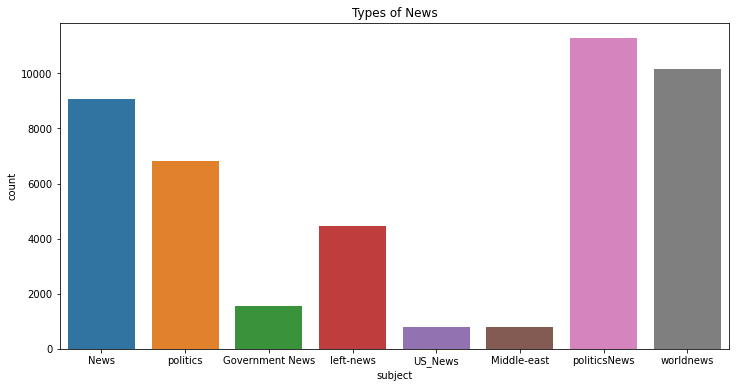

In [25]:
plt.figure(figsize=(12,6))
sns.countplot(x='subject', data= clean_news)
plt.title('Types of News')

In [26]:
from textblob import TextBlob

In [27]:
clean_news['polarity']= clean_news['news'].map(lambda review: TextBlob(review).sentiment.polarity)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


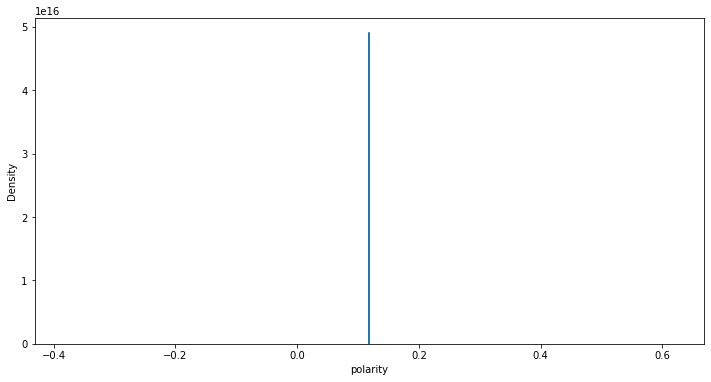

In [28]:
plt.figure(figsize=(12,6))
sns.distplot(clean_news['polarity'])

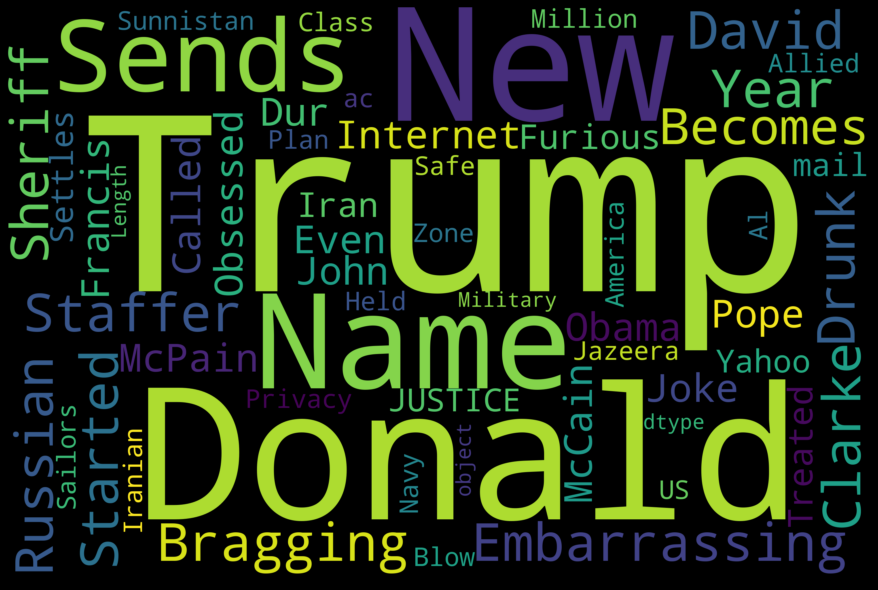

In [29]:
text = fake_news["news"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (15, 8),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

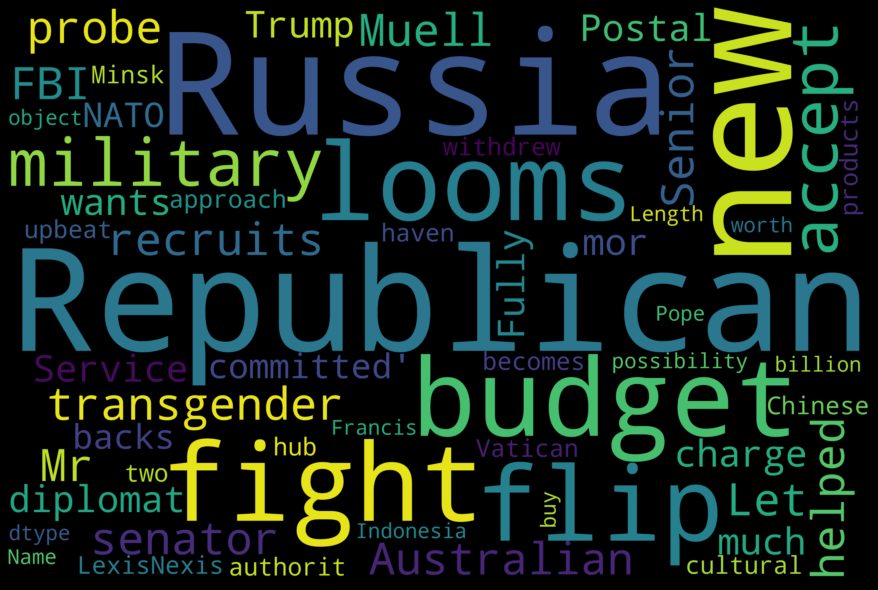

In [30]:
text= true_news['news']
wordcloud= WordCloud(
    height=2000,
    width= 3000,
    stopwords= STOPWORDS
).generate(str(text))

plt.figure(figsize=(15,8), facecolor='k', edgecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [31]:
corpus=[]
porter= PorterStemmer()
for i in range(len(news)):
  review= re.sub('[^a-zA-Z]', ' ', news_head['news'][i])
  review = re.sub('\[.*?\]', '', review)
  review = re.sub('https?://\S+|www\.\S+', '', review)
  review = re.sub('<.*?>+', '', review)
  review = re.sub('[%s]' % re.escape(string.punctuation), '', review)
  review = re.sub('\n', '', review)
  review = re.sub('\w*\d\w*', '', review)
  review= review.lower()
  review= review.split()

  review= [porter.stem(word) for word in review if not word in stopwords.words('english')]
  review= ' '.join(review)
  corpus.append(review)

In [32]:
corpus[:2]

['donald trump send embarrass new year eve messag disturbingdonald trump wish american happi new year leav instead give shout enemi hater dishonest fake news media former realiti show star one job countri rapidli grow stronger smarter want wish friend support enemi hater even dishonest fake news media happi healthi new year presid angri pant tweet great year america countri rapidli grow stronger smarter want wish friend support enemi hater even dishonest fake news media happi healthi new year great year america donald j trump realdonaldtrump decemb trump tweet went welll expect kind presid send new year greet like despic petti infantil gibberish trump lack decenc even allow rise gutter long enough wish american citizen happi new year bishop talbert swan talbertswan decemb one like calvin calvinstowel decemb impeach would make great year america also accept regain control congress miranda yaver mirandayav decemb hear talk includ mani peopl hate wonder hate alan sandov alansandov decemb 

In [33]:
y= news['output']

### TFIDF Vectorizer

In [34]:
tf_v= TfidfVectorizer(max_features=5000, ngram_range=(1,3))
X= tf_v.fit_transform(corpus).toarray()
X.shape

(44888, 5000)

In [35]:
y.shape

(44888,)

In [36]:
X_train, x_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=0)

classifier= MultinomialNB()
classifier.fit(X_train, y_train)
y_pred= classifier.predict(x_test)
print('Accuracy Score', accuracy_score(y_test,y_pred))

Accuracy Score 0.9408554243706839


## Deep Learning - LSTM

In [37]:
# define vocabulary list
voc_size = 10000
onehot_repr = [one_hot(word,voc_size) for word in corpus]
onehot_repr[:10]

[[2895,
  6209,
  5655,
  7590,
  5093,
  7262,
  613,
  3855,
  5648,
  6209,
  4068,
  8787,
  101,
  5093,
  7262,
  1852,
  6161,
  3630,
  5204,
  8470,
  1733,
  8469,
  1468,
  3425,
  1848,
  3185,
  9337,
  4157,
  2047,
  1886,
  1003,
  3175,
  2863,
  8637,
  6742,
  7811,
  7727,
  4068,
  3317,
  7054,
  8470,
  1733,
  2690,
  8469,
  1468,
  3425,
  1848,
  101,
  7055,
  5093,
  7262,
  9550,
  7991,
  3661,
  7384,
  5327,
  7262,
  3464,
  3175,
  2863,
  8637,
  6742,
  7811,
  7727,
  4068,
  3317,
  7054,
  8470,
  1733,
  2690,
  8469,
  1468,
  3425,
  1848,
  101,
  7055,
  5093,
  7262,
  5327,
  7262,
  3464,
  2895,
  5646,
  6209,
  1550,
  4419,
  6209,
  7384,
  6474,
  6840,
  8014,
  6176,
  9550,
  5655,
  5093,
  7262,
  9928,
  2462,
  3304,
  5704,
  7937,
  9175,
  6209,
  8435,
  5087,
  2690,
  7199,
  329,
  5537,
  9803,
  5634,
  4068,
  8787,
  4970,
  101,
  5093,
  7262,
  3115,
  1811,
  9746,
  8297,
  4419,
  1886,
  2462,
  4238,
  94,


### Embedded layer

In [38]:
sent_length= 5000
embedded_docs= pad_sequences(onehot_repr, padding='pre', maxlen=sent_length)
embedded_docs[0]

array([   0,    0,    0, ..., 9267, 9938, 7200], dtype=int32)

### LSTM Model

In [39]:
#Creating the lstm model
embedding_vector_features=50
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100)) #Adding 100 lstm neurons in the layer
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))

#Compiling the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 5000, 50)          500000    
_________________________________________________________________
dropout (Dropout)            (None, 5000, 50)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               60400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 560,501
Trainable params: 560,501
Non-trainable params: 0
_________________________________________________________________
None


In [40]:
X_final= np.array(embedded_docs)
y_final= np.array(y)

print(X_final.shape)
print(y_final.shape)

(44888, 5000)
(44888,)


In [41]:
X_train, x_test, y_train, y_test= train_test_split(X_final,y_final, test_size=0.3, random_state=1)

model.fit(X_train,y_train, epochs=10, validation_data=(x_test,y_test), batch_size=32)

Epoch 1/10
982/982 [==============================] - 241s 217ms/step - loss: 0.2221 - accuracy: 0.9038 - val_loss: 0.0879 - val_accuracy: 0.9755
Epoch 2/10
982/982 [==============================] - 212s 216ms/step - loss: 0.0698 - accuracy: 0.9779 - val_loss: 0.0923 - val_accuracy: 0.9670
Epoch 3/10
982/982 [==============================] - 213s 217ms/step - loss: 0.0497 - accuracy: 0.9840 - val_loss: 0.0837 - val_accuracy: 0.9756
Epoch 4/10
982/982 [==============================] - 214s 218ms/step - loss: 0.0361 - accuracy: 0.9891 - val_loss: 0.0590 - val_accuracy: 0.9822
Epoch 5/10
982/982 [==============================] - 213s 217ms/step - loss: 0.0315 - accuracy: 0.9917 - val_loss: 0.0447 - val_accuracy: 0.9877
Epoch 6/10
982/982 [==============================] - 214s 218ms/step - loss: 0.0286 - accuracy: 0.9907 - val_loss: 0.0448 - val_accuracy: 0.9886
Epoch 7/10
982/982 [==============================] - 214s 218ms/step - loss: 0.0319 - accuracy: 0.9915 - val_loss: 0.0579 -

In [42]:
y_pred=model.predict_classes(x_test)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Text(0.5, 1.0, 'Confusion matrix')

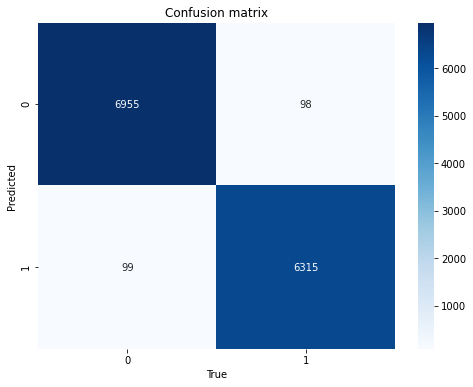

In [45]:
data= confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(data, annot=True, fmt='d', cmap='Blues')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Confusion matrix')

In [44]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7053
           1       0.98      0.98      0.98      6414

    accuracy                           0.99     13467
   macro avg       0.99      0.99      0.99     13467
weighted avg       0.99      0.99      0.99     13467

